In [1]:
import torch
from torch.autograd import Variable
from torch import optim

import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = np.loadtxt('../large_files/train.csv', delimiter=',', skiprows=1, dtype=int)

def set_up_data(d):
    # shuffle the data
    np.random.shuffle(d)

    # split into X and Y (labels are first column)
    X = d[:, 1:]
    Y = d[:, 0]

    # split into train/test
    r, c = np.shape(d)
    r_90 = r // 90
    X_train, X_test = X[:-r_90], X[-r_90:]
    Y_train, Y_test = Y[:-r_90], Y[-r_90:]

    # normalize.
    # takes mean/std for each col (??)
    mu = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    
    # for all-black images (std == 0), change std to 1 to prevent /0 errors
    idx = np.where(std == 0)[0]
    assert(np.all(std[idx]) == 0)

    np.place(std, std == 0, 1)

    X_train = (X_train - mu) / std
    X_test = (X_test - mu) / std
    
    return X_train, X_test, Y_train, Y_test

def onehot_encode(y):
    N = len(y)
    min_y, max_y = np.min(y), np.max(y)
    K = (max_y - min_y) + 1

    encoded_y = np.zeros((N, K))

    for i in range(N):
        col_val = y[i]
        encoded_y[i, col_val] = 1
    
    return encoded_y

def error_rate(p, t):
    return np.mean(p != t)

/Users/robbydivine/anaconda3/envs/dl/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 0, cost: 0.201424, acc: 0.93
Epoch: 1, cost: 0.158125, acc: 0.95
Epoch: 2, cost: 0.137182, acc: 0.96
Epoch: 3, cost: 0.127914, acc: 0.96
Epoch: 4, cost: 0.125751, acc: 0.97
Epoch: 5, cost: 0.127951, acc: 0.97
Epoch: 6, cost: 0.128887, acc: 0.97
Epoch: 7, cost: 0.134608, acc: 0.97
Epoch: 8, cost: 0.142778, acc: 0.97
Epoch: 9, cost: 0.155883, acc: 0.97
Epoch: 10, cost: 0.162787, acc: 0.97
Epoch: 11, cost: 0.185107, acc: 0.97
Epoch: 12, cost: 0.167594, acc: 0.96
Epoch: 13, cost: 0.180669, acc: 0.97
Epoch: 14, cost: 0.268907, acc: 0.96


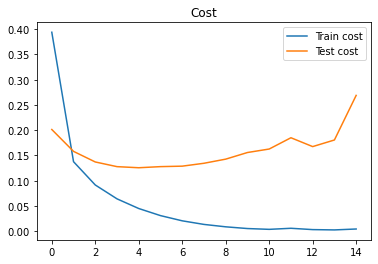

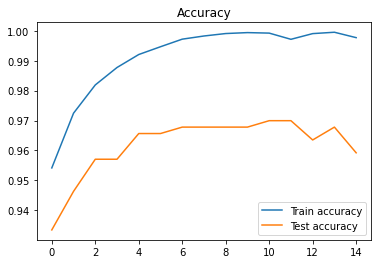

In [3]:
# get the data, same as Theano + Tensorflow examples
# no need to split now, the fit() function will do it
Xtrain, Xtest, Ytrain, Ytest = set_up_data(data)

# get shapes
_, D = Xtrain.shape
K = len(set(Ytrain))

# Note: no need to convert Y to indicator matrix


# the model will be a sequence of layers
model = torch.nn.Sequential()


# ANN with layers [784] -> [500] -> [300] -> [10]
# dropout (p = p drop, not p keep):
# batchnorm also added.
# model.add_module("dropout1", torch.nn.Dropout(p=0.2))
model.add_module("dense1", torch.nn.Linear(D, 500))
# model.add_module("bn1", torch.nn.BatchNorm1d(500))
model.add_module("relu1", torch.nn.ReLU())
# model.add_module("dropout2", torch.nn.Dropout(p=0.5)
model.add_module("dense2", torch.nn.Linear(500, 300))
# model.add_module("bn2", torch.nn.BatchNorm1d(300))
model.add_module("relu2", torch.nn.ReLU())
# model.add_module("dropout3", torch.nn.Dropout(p=0.5))
model.add_module("dense3", torch.nn.Linear(300, K))
# Note: no final softmax!
# just like Tensorflow, it's included in cross-entropy function


# define a loss function
# other loss functions can be found here:
# http://pytorch.org/docs/master/nn.html#loss-functions
loss = torch.nn.CrossEntropyLoss(size_average=True)
# Note: this returns a function!
# e.g. use it like: loss(logits, labels)


# define an optimizer
# other optimizers can be found here:
# http://pytorch.org/docs/master/optim.html
optimizer = optim.Adam(model.parameters(), lr=1e-4)



# define the training procedure
# i.e. one step of gradient descent
# there are lots of steps
# so we encapsulate it in a function
# Note: inputs and labels are torch tensors
def train(model, loss, optimizer, inputs, labels):
  # need below model.train() line if using dropout, 
  # since dropout requires specifying between train vs eval modes
  # model.train()

  inputs = Variable(inputs, requires_grad=False)
  labels = Variable(labels, requires_grad=False)

  # Reset gradient
  optimizer.zero_grad()

  # Forward
  logits = model.forward(inputs)
  # ouput: "think of it like a scalar (float), but torch's version with methods"
  output = loss.forward(logits, labels)

  # Backward
  output.backward()

  # Update parameters
  optimizer.step()

  # what's the difference between backward() and step()?

  # output.item() returns the actual loss value

  return output.item()


# similar to train() but not doing the backprop step
def get_cost(model, loss, inputs, labels):
  # need below uncommented if using dropout
  # model.eval() 
  inputs = Variable(inputs, requires_grad=False)
  labels = Variable(labels, requires_grad=False)

  # Forward
  logits = model.forward(inputs)
  output = loss.forward(logits, labels)

  return output.item()


# define the prediction procedure
# also encapsulate these steps
# Note: inputs is a torch tensor
def predict(model, inputs):
  # need model.eval() to get into eval mode if using dropout
  # model.eval()

  inputs = Variable(inputs, requires_grad=False)
  logits = model.forward(inputs)
  return logits.data.numpy().argmax(axis=1)


# return the accuracy
# labels is a torch tensor
# to get back the internal numpy data
# use the instance method .numpy()
def score(model, inputs, labels):
  predictions = predict(model, inputs)
  return np.mean(labels.numpy() == predictions)


### prepare for training loop ###

# convert the data arrays into torch tensors
Xtrain = torch.from_numpy(Xtrain).float()
Ytrain = torch.from_numpy(Ytrain).long()
Xtest = torch.from_numpy(Xtest).float()
Ytest = torch.from_numpy(Ytest).long()

# training parameters
epochs = 15
batch_size = 32
n_batches = Xtrain.size()[0] // batch_size

# things to keep track of
train_costs = []
test_costs = []
train_accuracies = []
test_accuracies = []

# main training loop
for i in range(epochs):
  cost = 0
  test_cost = 0
  for j in range(n_batches):
    Xbatch = Xtrain[j*batch_size:(j+1)*batch_size]
    Ybatch = Ytrain[j*batch_size:(j+1)*batch_size]
    cost += train(model, loss, optimizer, Xbatch, Ybatch)

  
  # we could have also calculated the train cost here
  # but I wanted to show you that we could also return it
  # from the train function itself
  train_acc = score(model, Xtrain, Ytrain)
  test_acc = score(model, Xtest, Ytest)
  test_cost = get_cost(model, loss, Xtest, Ytest)

  print("Epoch: %d, cost: %f, acc: %.2f" % (i, test_cost, test_acc))

  # for plotting
  train_costs.append(cost / n_batches)
  train_accuracies.append(train_acc)
  test_costs.append(test_cost)
  test_accuracies.append(test_acc)



# plot the results
plt.plot(train_costs, label='Train cost')
plt.plot(test_costs, label='Test cost')
plt.title('Cost')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Train accuracy')
plt.plot(test_accuracies, label='Test accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()